In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from matplotlib.animation import FuncAnimation, FFMpegWriter # Import FFMpegWriter

# --- 1. Setup ---
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# --- 2. Input Preparation ---
input_text = "The dog barked at the mailman, who ran away."
inputs = tokenizer(input_text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
# Clean up tokens for better plotting (remove the 'Ġ' for display)
display_tokens = [t.replace('Ġ', ' ') for t in tokens]

print(f"Input Tokens: {tokens}")
print("-" * 30)

# --- 3. Forward Pass to Extract Weights ---
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

attention_weights = outputs.attentions
NUM_LAYERS = len(attention_weights)
print(f"Total Attention Layers Found: {NUM_LAYERS}")

# --- 4. Prepare Matrices for Animation ---
# List to hold the average attention matrix for each layer
average_matrices = []
for layer_tensor in attention_weights:
    # Average across the heads: (1, Heads, Q, K) -> (Q, K)
    average_matrix = layer_tensor[0].mean(dim=0).detach().cpu().numpy()
    average_matrices.append(average_matrix)

# Prepare the plot figure once
fig, ax = plt.subplots(figsize=(8, 7))

# Initialize a fixed color normalization (0 to 1)
from matplotlib.colors import Normalize
fixed_norm = Normalize(vmin=0.0, vmax=1.0) 

# Initialize the heatmap with the first layer's data
# We save the artist returned by sns.heatmap()
im = sns.heatmap(
    average_matrices[0],
    ax=ax,
    xticklabels=display_tokens,
    yticklabels=display_tokens,
    cmap='viridis',
    linewidths=.5,
    linecolor='lightgray',
    cbar_kws={'label': 'Attention Weight'},
    vmin=0.0,
    vmax=1.0,
    norm=fixed_norm
)
ax.set_xlabel('Key (Attended To) Tokens', fontsize=10)
ax.set_ylabel('Query (Attending) Tokens', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()

# Crucial Step: Extract the actual data collection object from the heatmap artist.
# This object is what needs to be updated. It's usually the first 'collections' item.
# This is what holds the colored cells.
heatmap_collection = im.collections[0] 


# --- 6. The Animation Update Function (MODIFIED) ---
def update_plot(layer_num):
    """
    Updates the heatmap data for the current layer number.
    """
    matrix = average_matrices[layer_num]
    
    # CORRECT UPDATE: Update the data in the collection object
    # The data needs to be flattened (1D) for the collection object's set_array() method.
    heatmap_collection.set_array(matrix.flatten())
    
    # Update the title to show the current layer number
    ax.set_title(f'Layer {layer_num} / {NUM_LAYERS - 1} - Avg. Attention', fontsize=12)
    
    # Return the artist to be redrawn
    return [heatmap_collection]


# --- 7. Create the Animation and Save as MP4 ---

# Create the animation object
# frames=NUM_LAYERS ensures it iterates through all layers
# interval=800 sets the delay between frames to 800ms (0.8 seconds)
ani = FuncAnimation(fig, update_plot, frames=NUM_LAYERS, interval=800, blit=False)

# Set up the writer (requires FFmpeg)
writer = FFMpegWriter(fps=1.0 / (800 / 1000), metadata=dict(artist='Me'), bitrate=1800)
# Note: fps is 1 frame per 0.8 seconds, or 1.25 fps

# Save the animation as an MP4 file
output_filename = 'attention_evolution.mp4'
print(f"\n--- Saving Animation to {output_filename} ---")

try:
    ani.save(output_filename, writer=writer)
    print("Video saved successfully!")
except Exception as e:
    print(f"\nERROR saving video: {e}")
    print("This often means FFmpeg is not installed or not found by Matplotlib.")
    print("You might need to install FFmpeg via a package manager (e.g., `sudo apt install ffmpeg`).")

plt.close(fig) # Close the plot figure handle

Input Tokens: ['The', 'Ġdog', 'Ġbark', 'ed', 'Ġat', 'Ġthe', 'Ġmail', 'man', ',', 'Ġwho', 'Ġran', 'Ġaway', '.']
------------------------------
Total Attention Layers Found: 6

--- Saving Animation to attention_evolution.mp4 ---
Video saved successfully!


In [7]:
pip install ffmpeg

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=984ad435083f10f8932f2bedf54156947bfc3d5b8c306a2770b245833a109302
  Stored in directory: /root/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg
Note: you may need to restart the kernel to use updated packages.



--- Loading and Processing: distilgpt2 ---
Input Tokens (13): ['The', 'Ġdog', 'Ġbark', 'ed', 'Ġat', 'Ġthe', 'Ġmail', 'man', ',', 'Ġwho', 'Ġran', 'Ġaway', '.']
Shape of Layer 0 Avg. Attention Matrix: (13, 13)

--- Loading and Processing: gpt2 ---


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Input Tokens (13): ['The', 'Ġdog', 'Ġbark', 'ed', 'Ġat', 'Ġthe', 'Ġmail', 'man', ',', 'Ġwho', 'Ġran', 'Ġaway', '.']
Shape of Layer 0 Avg. Attention Matrix: (13, 13)

--- Loading and Processing: bert-base-uncased ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Input Tokens (14): ['[CLS]', 'the', 'dog', 'barked', 'at', 'the', 'mail', '##man', ',', 'who', 'ran', 'away', '.', '[SEP]']
Shape of Layer 0 Avg. Attention Matrix: (14, 14)


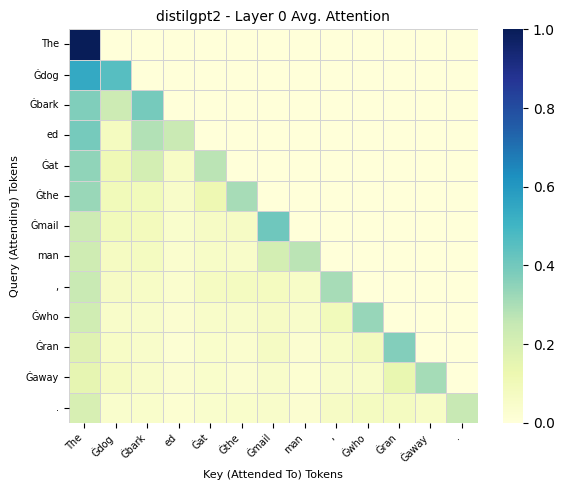

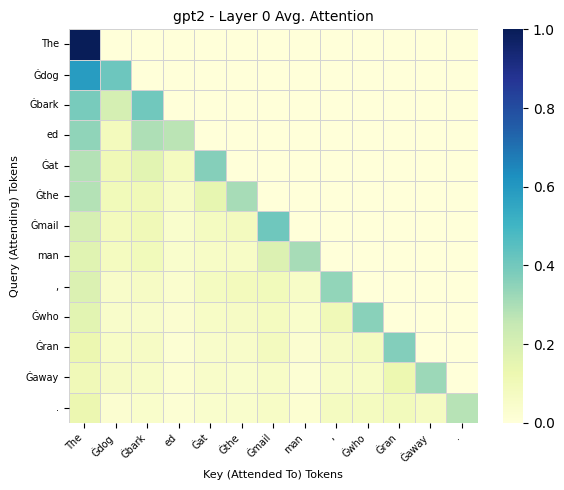

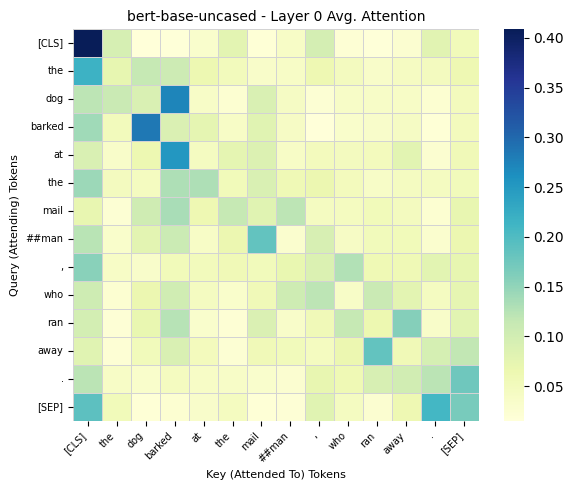


--- Comparative Insights ---
1. Tokenization Difference: Notice how 'distilgpt2' uses 'Ġdog' while 'bert-base-uncased' uses '[CLS]', 'the', 'dog', '[SEP]'. The labels are different!
2. Causal vs. Bidirectional: The GPT models (Decoder-only) will often show attention matrices that are mostly empty (dark) in the upper-right triangle. This is due to **causal masking**—tokens can only attend to tokens that came before them (including themselves). BERT (Encoder-only) will show attention in the full square, as it is **bidirectional**.
3. Attention Patterns: Compare the coreference pattern ('who' attending to 'mailman'). It might be stronger in one model than another, or handled by different heads/layers.


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel

# --- 1. Configuration and Models ---
# The models we will compare
MODEL_CONFIGS = [
    {"name": "distilgpt2", "model_class": AutoModelForCausalLM},
    {"name": "gpt2", "model_class": AutoModelForCausalLM},
    # Using AutoModel for BERT since it's an Encoder-only model
    {"name": "bert-base-uncased", "model_class": AutoModel}, 
]
INPUT_TEXT = "The dog barked at the mailman, who ran away."
LAYER_TO_VISUALIZE = 0 # Visualize the first layer for all models

# --- 2. Unified Plotting Function ---
def plot_attention_map(attention_matrix, tokens, model_name, layer_num):
    """Plots a single attention matrix heatmap."""
    plt.figure(figsize=(6, 5))
    # Using 'YlGnBu' for visual distinction, but 'viridis' or 'coolwarm' work too
    sns.heatmap(
        attention_matrix,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='YlGnBu',
        linewidths=.5,
        linecolor='lightgray'
    )
    plt.title(f'{model_name} - Layer {layer_num} Avg. Attention', fontsize=10)
    plt.xlabel('Key (Attended To) Tokens', fontsize=8)
    plt.ylabel('Query (Attending) Tokens', fontsize=8)
    plt.xticks(rotation=45, ha='right', fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
    plt.tight_layout()

# --- 3. Main Comparison Loop ---
all_tokens = {}
all_matrices = {}

for config in MODEL_CONFIGS:
    model_name = config["name"]
    model_class = config["model_class"]
    
    print(f"\n--- Loading and Processing: {model_name} ---")
    
    # Load Model and Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = model_class.from_pretrained(model_name)
    
    # Tokenization (Note: Tokenizers differ, so tokens will likely be different!)
    inputs = tokenizer(INPUT_TEXT, return_tensors="pt")
    input_ids = inputs['input_ids']
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0], skip_special_tokens=False)
    
    # Store tokens for consistent plotting labels
    all_tokens[model_name] = tokens
    
    print(f"Input Tokens ({len(tokens)}): {tokens}")
    
    # Forward Pass to Extract Weights
    # Encoder-only models (like BERT) store attention in 'attentions', not 'causal_attention'
    with torch.no_grad():
        # Ensure we always get attention output
        outputs = model(**inputs, output_attentions=True)

    attention_weights = outputs.attentions
    
    if attention_weights is None:
        print(f"ERROR: Could not retrieve attention weights for {model_name}.")
        continue

    # Extract the specified layer's attention
    layer_attention = attention_weights[LAYER_TO_VISUALIZE]
    
    # Average across the batch and the heads
    # Shape: (Batch, Heads, Query Length, Key Length) -> (Query Length, Key Length)
    # The [0] index accesses the single item in the batch
    average_attention_matrix = layer_attention[0].mean(dim=0).detach().cpu().numpy()
    
    all_matrices[model_name] = average_attention_matrix
    print(f"Shape of Layer {LAYER_TO_VISUALIZE} Avg. Attention Matrix: {average_attention_matrix.shape}")


# --- 4. Side-by-Side Visualization ---

# We will plot the attention maps, but must use the tokens specific to each model.
# Since the tokenizers are different, the sequence lengths might also differ!

for name, matrix in all_matrices.items():
    plot_attention_map(matrix, all_tokens[name], name, LAYER_TO_VISUALIZE)

plt.show()

# --- 5. Comparison Insights ---
print("\n--- Comparative Insights ---")
print("1. Tokenization Difference: Notice how 'distilgpt2' uses 'Ġdog' while 'bert-base-uncased' uses '[CLS]', 'the', 'dog', '[SEP]'. The labels are different!")
print("2. Causal vs. Bidirectional: The GPT models (Decoder-only) will often show attention matrices that are mostly empty (dark) in the upper-right triangle. This is due to **causal masking**—tokens can only attend to tokens that came before them (including themselves). BERT (Encoder-only) will show attention in the full square, as it is **bidirectional**.")
print("3. Attention Patterns: Compare the coreference pattern ('who' attending to 'mailman'). It might be stronger in one model than another, or handled by different heads/layers.")